In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from collections import deque
import matplotlib.pyplot as plt


In [11]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

In [12]:
env.action_space.n, env.observation_space.shape[0]

(2, 4)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)

In [14]:
class DQN(nn.Module):
    def __init__(self, lr):
        super(DQN, self).__init__()
        
        self.lr = lr
        self.memory = []
        self.fc1 = nn.Linear(env.observation_space.shape[0],128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,env.action_space.n)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class memory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
    
    def push(self, arr):
        self.memory.append(arr)

    def get_mini_batch(self, batch_size):
        return rd.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)
    
def get_action(obs, eps):
    global epslist,steps_done
    eps = 0.05 + (0.9 - 0.05) * math.exp(-1. * steps_done / 1000)
    steps_done += 1
    epslist.append(eps)
    if np.random.random() > eps:
        with torch.no_grad():
            return policy_model(torch.tensor(obs, device=device).unsqueeze(0)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimization(target_model, policy_model, memory, batch_size):
    global d_factor, loss
    criterion = nn.HuberLoss().to(device)
    optimizer = optim.Adam(policy_model.parameters(), lr = policy_model.lr)
    observation_batch, action_batch, reward_batch, new_observation_batch = [], [], [], []
    done_mask = deque([])
    if len(memory) < batch_size:
        return
    else:
        batch = memory.get_mini_batch(batch_size)
    
    for i in range(batch_size):
        observation_batch.append(torch.tensor(batch[i][0], device=device))
        action_batch.append(torch.tensor(batch[i][1],device=device))
        reward_batch.append(torch.tensor(batch[i][3], device=device))
        if batch[i][2] is not None:
            new_observation_batch.append(torch.tensor(batch[i][2], device=device))
            done_mask.append(torch.tensor(True))
        else:
            done_mask.append(torch.tensor(False))

    observation_batch = torch.stack(observation_batch)
    action_batch = torch.stack(action_batch)
    reward_batch = torch.stack(reward_batch)
    new_observation_batch = torch.stack(new_observation_batch)
    # print(action_batch)
    masked_state = torch.zeros(batch_size, device=device)
    # print(new_observation_batch.shape)

    # print((d_factor * target_model(torch.stack([batch[i][2] for i in range(batch_size)]).to(device))).size())
    # print(policy_model(observation_batch.to(device)).shape, action_batch.shape)
    y_hat = policy_model(observation_batch).gather(1, action_batch)
    # print(y_hat.shape)
    with torch.no_grad():
        masked_state[done_mask] = target_model(new_observation_batch).max(1)[0]
    
    y = masked_state * d_factor + reward_batch
    # print(reward_batch.shape)
    # print(y.shape)
    optimizer.zero_grad()
    
    cost = criterion(y_hat, y.reshape(-1,1))
    loss.append(float(cost))
    # print(cost)
    # print(y_hat, y.reshape(-1,1),y.shape, y_hat.shape)
    cost.backward()
    optimizer.step()

episode_durations = []

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html

In [15]:
batch_size = 128
gamma = 0.99
epochs = 600
d_factor = 0.95
lr = 1e-4
seta = 0.005
steps_done = 0
loss = []

In [16]:
policy_model = DQN(lr = lr).to(device)
target_model = DQN(lr = lr).to(device)
target_model.load_state_dict(policy_model.state_dict())

<All keys matched successfully>

In [17]:
torch.tensor(env.reset()[0]).reshape(-1,1)

tensor([[ 0.0105],
        [ 0.0098],
        [-0.0317],
        [-0.0117]])

599 10
Complete


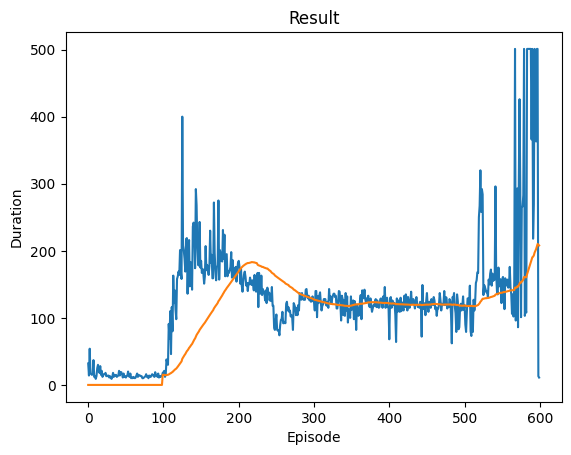

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
timelist = [0]
epslist = []
memory = memory(10000)

for epoch in range(epochs):
    
    state = env.reset()[0]
    rd.seed(777)
    done = False
    time = 0
    
    while not done:
        if (epoch + 1) % 100 == 0:
            screen = env.render()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.title(str(epoch) + " " + str(time))
            plt.imshow(screen)
        
        time += 1  
        action = get_action(state, policy_model)
        
        new_observation, reward, done, truncated, _ =  env.step(action.item())

        done = done or truncated
        
        if done:
            next_state = None
        else:
            next_state = new_observation
        # print(tuple(map(torch.tensor,(observation, action, new_observation, reward))))
        memory.push((state, [action], next_state, reward))
        state = next_state
    
        optimization(target_model, policy_model, memory, batch_size)
        
        target_net_state_dict = target_model.state_dict()
        policy_net_state_dict = policy_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*seta + target_net_state_dict[key]*(1-seta)
        target_model.load_state_dict(target_net_state_dict)
        if done:
                episode_durations.append(time + 1)
                plot_durations()
                break
    timelist.append(time)
    if (epoch+1) % 100 == 0:
        print(epoch, time) 
    
        

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

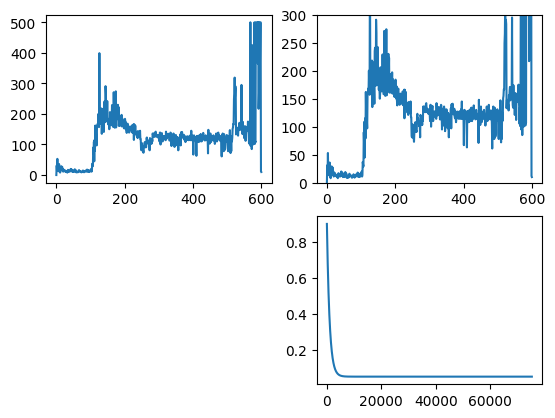

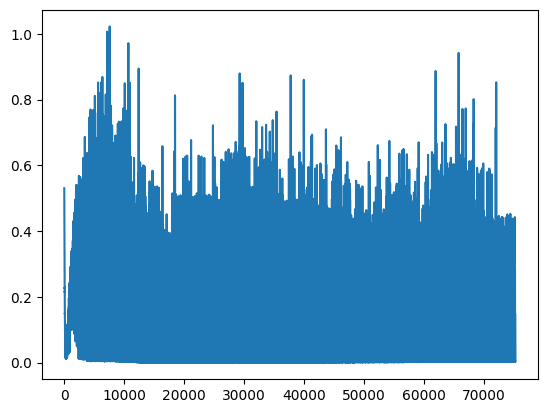

In [19]:
plt.subplot(2,2,1)
plt.plot(range(len(timelist)),timelist)
plt.subplot(2,2,2)
plt.plot(range(len(timelist)),timelist)
plt.ylim(0, 300)
plt.subplot(2,2,4)
plt.plot(range(len(epslist)),epslist)
plt.show()

plt.plot(range(len(loss)),loss)
plt.show()